# Data Pipeline

## A. Import Library

In [47]:
import os     # for interacting with directory
import numpy as np     # for calculation
import pandas as pd     # for manipulating DataFrame
import seaborn as sns     # for plotting data
import matplotlib.pyplot as plt     # for plotting data
import yaml     # for interacting with config.yaml  
import src.util as util     # import common function
from sklearn.model_selection import train_test_split     # for splitting train and test data

## B. Import Raw Data

In [48]:
config = util.load_config()
config

{'raw_dataset_dir': 'data/raw/',
 'raw_data_path': 'data/processed/raw_data.pkl',
 'data_train_path': ['data/processed/X_train_clean.pkl',
  'data/processed/y_train_clean.pkl'],
 'data_test_path': ['data/processed/X_test_clean.pkl',
  'data/processed/y_test_clean.pkl'],
 'data_modeling_path': ['data/processed/train_data_modeling.pkl',
  'data/processed/test_data_modeling.pkl'],
 'ohe_train_path': 'models/ohe_train.pkl',
 'standard_scaler_path': 'models/standard_scaler_train.pkl',
 'modeling_summary': 'models/modeling_summary.pkl',
 'production_model': 'models/production_model.pkl',
 'api_columns': ['GR', 'ILD_log10', 'DeltaPHI', 'PHIND', 'PE', 'NM_M']}

In [49]:
def populate_raw_data(directory:str) -> pd.DataFrame:
    raw_data = pd.DataFrame()
    for well_data in os.listdir(directory):
        raw_data = pd.concat([raw_data,pd.read_csv(directory+well_data)],
                             axis=0,
                             ignore_index=True)
    print(f"raw data consist of {raw_data.shape[0]} row, and {raw_data.shape[1]} columns")
    return raw_data

In [50]:
raw_data = populate_raw_data(directory=config["raw_dataset_dir"])

raw data consist of 4149 row, and 11 columns


In [51]:
util.dump_pickle(raw_data,config["raw_data_path"])

In [52]:
raw_data.head(5)

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,CSiS,A1 SH,NOLAN,2853.5,106.813,0.533,9.339,15.222,3.500,1,1.000
1,FSiS,A1 SH,NOLAN,2854.0,100.938,0.542,8.857,15.313,3.416,1,0.977
2,FSiS,A1 SH,NOLAN,2854.5,94.375,0.553,7.097,14.583,3.195,1,0.955
3,FSiS,A1 SH,NOLAN,2855.0,89.813,0.554,7.081,14.110,2.963,1,0.932
4,FSiS,A1 SH,NOLAN,2855.5,91.563,0.560,6.733,13.189,2.979,1,0.909


In [53]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4149 entries, 0 to 4148
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Facies     4149 non-null   object 
 1   Formation  4149 non-null   object 
 2   Well Name  4149 non-null   object 
 3   Depth      4149 non-null   float64
 4   GR         4149 non-null   float64
 5   ILD_log10  4149 non-null   float64
 6   DeltaPHI   4149 non-null   float64
 7   PHIND      4149 non-null   float64
 8   PE         3232 non-null   float64
 9   NM_M       4149 non-null   int64  
 10  RELPOS     4149 non-null   float64
dtypes: float64(7), int64(1), object(3)
memory usage: 356.7+ KB


In [54]:
raw_data.describe()

,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,3232.000000,4149.000000,4149.000000
mean,2906.867438,64.933985,0.659566,4.402484,13.201066,3.725014,1.518438,0.521852
std,133.300164,30.302530,0.252703,5.274947,7.132846,0.896152,0.499720,0.286644
min,2573.500000,10.149000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.000000
25%,2821.500000,44.730000,0.498000,1.600000,8.500000,3.100000,1.000000,0.277000
50%,2932.500000,64.990000,0.639000,4.300000,12.020000,3.551500,2.000000,0.528000
75%,3007.000000,79.438000,0.822000,7.500000,16.050000,4.300000,2.000000,0.769000
max,3138.000000,361.150000,1.800000,19.312000,84.400000,8.094000,2.000000,1.000000


In [55]:
raw_data.isnull().sum()

Facies         0
Formation      0
Well Name      0
Depth          0
GR             0
ILD_log10      0
DeltaPHI       0
PHIND          0
PE           917
NM_M           0
RELPOS         0
dtype: int64

We found that there are missing data in **PE** column, hence this raw data need data cleaning first

## C. Data Overview

There are seven predictor variable for the facies label : 

Features | Explanation | Value | Measurement Type
:---: | :--: | :--: | :--: 
GR | Gamma Ray | 10.14 - 361.15 | Wireline Measurement 
ILD_log10 | Resistivity Logging | -0.03 - 1.8 | Wireline Measurement 
PE | Photoelectric Effect | 0.2 - 8.09 | Wireline Measurement
DeltaPHI | Neutron-Density Porosity Difference | -21.83 - 19.31 | Wireline Measurement 
PHIND | Average Neutron-Density Porosity | 0.55 - 84.4 | Wireline Measurement
NM_M | Non-Marine Marine Indicator | 1 or 2 |  Geologic Constraining Variables 
RELPOS | Relative Position | 0 - 1 | Geologic Constraining Variables

And there are nine different facies labels :

Facies| Adjacent Facies | Classes of Rocks 
:---: |:--: |:--:
SS| CSiS | Sandstone
CSiS| SS,FSiS | Coarse Siltstone
FSiS| CSiS | Fine Siltstone
SiSh| MS | Marine Siltstone and Shale
MS| SiSh,WS | Mudstone (limestone)
WS| MS,D | Wackestone (limestone)
D| WS,PS | Dolomite
PS| WS,D,BS | Packstone-grainstone (limestone)
BS| D, PS | Phylloid-algal bafflestone (limestone)

<AxesSubplot:xlabel='count', ylabel='Well Name'>

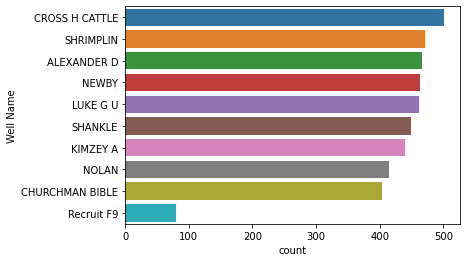

In [56]:
sns.countplot(data=raw_data, y="Well Name", order=raw_data["Well Name"].value_counts().index)

We have data from 10 well measurement : **NOLAN, LUKE G U, CROSS H CATTLE, KIMZEY A, SHRIMPLIN, NEWBY, Recruit F9, SHANKLE, CHURCHMAN BIBLE, and ALEXANDER D**. Value counts shows us that for every well the amount is simillar except Recruit F9 well which just has 80 raw data.

In [57]:
raw_data["Facies"].value_counts(normalize=True)

CSiS    0.226561
FSiS    0.187997
PS      0.165341
WS      0.140275
MS      0.071342
SiSh    0.065317
SS      0.064594
BS      0.044589
D       0.033984
Name: Facies, dtype: float64

Value counts also show us that this raw data has **imbalance category** for facies.

## D. Split Train and Test Data

In [58]:
def split_train_test_data(raw_data:pd.DataFrame, output:'str'='Facies') -> pd.DataFrame:
    X=raw_data.drop(columns=output, axis=1)
    y=raw_data[output]
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=123, stratify=y)
    print(f"Train data consist of X_train : {X_train.shape[0]} row and y_train : {y_train.shape[0]} row")
    print(f"Test data consist of X_test : {X_test.shape[0]} row and y_test : {y_test.shape[0]} row")

    return X_train, y_train, X_test, y_test

In [59]:
X_train_unclean, y_train_unclean, X_test_unclean, y_test_unclean = split_train_test_data(raw_data = raw_data, output='Facies')


Train data consist of X_train : 3319 row and y_train : 3319 row
Test data consist of X_test : 830 row and y_test : 830 row


In [60]:
X_train_unclean.isnull().sum()

Formation      0
Well Name      0
Depth          0
GR             0
ILD_log10      0
DeltaPHI       0
PHIND          0
PE           750
NM_M           0
RELPOS         0
dtype: int64

In [61]:
y_train_unclean.isnull().sum()

0

In [62]:
X_test_unclean.isnull().sum()

Formation      0
Well Name      0
Depth          0
GR             0
ILD_log10      0
DeltaPHI       0
PHIND          0
PE           167
NM_M           0
RELPOS         0
dtype: int64

In [63]:
y_test_unclean.isnull().sum()

0

In [64]:
y_train_unclean.value_counts(normalize=True)

CSiS    0.226574
FSiS    0.188008
PS      0.165411
WS      0.140102
MS      0.071407
SiSh    0.065381
SS      0.064477
BS      0.044592
D       0.034046
Name: Facies, dtype: float64

In [65]:
y_test_unclean.value_counts(normalize=True)

CSiS    0.226506
FSiS    0.187952
PS      0.165060
WS      0.140964
MS      0.071084
SS      0.065060
SiSh    0.065060
BS      0.044578
D       0.033735
Name: Facies, dtype: float64

After splitting train and test data, we have null value for **Photo-Electric** measurement in both train data and test data, hence we need to handle this null value.

## E. Impute Data

In [66]:
def impute_PE_data_train(X_data:pd.DataFrame, y_data:pd.DataFrame) -> pd.DataFrame:
    if X_data["PE"].isnull().sum() == 0:
        pass
    else :
        data = pd.concat([X_data, y_data], axis=1)
        PE_mean_data = data.loc[~(data["PE"].isnull()),["Facies","PE"]].groupby("Facies").agg('mean')
        PE_nan_data = data.loc[data["PE"].isnull(),["Facies","PE"]]
        facies_labels = data["Facies"].unique().tolist()
        for facies in facies_labels:
            index_PE_nan_by_categories = PE_nan_data[PE_nan_data['Facies']==facies].index.to_list()    
            data.loc[index_PE_nan_by_categories,'PE'] = PE_mean_data.loc[facies].values[0]
        X_data = data.drop(columns='Facies', axis=1)
        y_data = data['Facies']
    return X_data, y_data

In [67]:
X_train_clean, y_train_clean = impute_PE_data_train(X_data=X_train_unclean, y_data=y_train_unclean)

In [68]:
data = pd.concat([X_train_unclean, y_train_unclean], axis=1)
PE_mean_data = data.loc[~(data["PE"].isnull()),["Facies","PE"]].groupby("Facies").agg('mean')
PE_mean_data

,PE
Facies,
BS,5.289046
CSiS,3.204093
D,3.722568
FSiS,3.130259
MS,3.961130
PS,4.517453
SS,2.918517
SiSh,3.805842
WS,4.234412


In [69]:
data = pd.concat([X_train_clean, y_train_clean], axis=1)
PE_mean_data = data.loc[~(data["PE"].isnull()),["Facies","PE"]].groupby("Facies").agg('mean')
PE_mean_data

,PE
Facies,
BS,5.289046
CSiS,3.204093
D,3.722568
FSiS,3.130259
MS,3.961130
PS,4.517453
SS,2.918517
SiSh,3.805842
WS,4.234412


In [70]:
X_train_clean.isnull().sum()

Formation    0
Well Name    0
Depth        0
GR           0
ILD_log10    0
DeltaPHI     0
PHIND        0
PE           0
NM_M         0
RELPOS       0
dtype: int64

In [71]:
y_train_clean.isnull().sum()

0

In [72]:
def impute_PE_data_test(X_data:pd.DataFrame, y_data:pd.DataFrame, X_imputer:pd.DataFrame, y_imputer:pd.DataFrame) -> pd.DataFrame:
    if X_data["PE"].isnull().sum() == 0:
        pass
    else :
        data = pd.concat([X_data, y_data], axis=1)
        imputer_data = pd.concat([X_imputer, y_imputer], axis=1)
        PE_mean_data = imputer_data.loc[~(imputer_data["PE"].isnull()),["Facies","PE"]].groupby("Facies").agg('mean')
        PE_nan_data = data.loc[data["PE"].isnull(),["Facies","PE"]]
        facies_labels = data["Facies"].unique().tolist()
        for facies in facies_labels:
            index_PE_nan_by_categories = PE_nan_data[PE_nan_data['Facies']==facies].index.to_list()    
            data.loc[index_PE_nan_by_categories,'PE'] = PE_mean_data.loc[facies].values[0]
        X_data = data.drop(columns='Facies', axis=1)
        y_data = data['Facies']
    return X_data, y_data

In [73]:
X_test_clean, y_test_clean = impute_PE_data_test(X_data=X_test_unclean, y_data=y_test_unclean,
                                                 X_imputer=X_train_unclean, y_imputer=y_train_unclean)

In [74]:
data = pd.concat([X_test_unclean, y_test_unclean], axis=1)
PE_mean_data = data.loc[~(data["PE"].isnull()),["Facies","PE"]].groupby("Facies").agg('mean')
PE_mean_data

,PE
Facies,
BS,5.324774
CSiS,3.259811
D,3.513167
FSiS,3.140258
MS,4.115083
PS,4.523143
SS,2.891560
SiSh,3.787974
WS,4.233011


In [75]:
data = pd.concat([X_test_clean, y_test_clean], axis=1)
PE_mean_data = data.loc[~(data["PE"].isnull()),["Facies","PE"]].groupby("Facies").agg('mean')
PE_mean_data

,PE
Facies,
BS,5.318980
CSiS,3.247956
D,3.543081
FSiS,3.138463
MS,4.086380
PS,4.521814
SS,2.893557
SiSh,3.793268
WS,4.233322


In [76]:
X_test_clean.isnull().sum()

Formation    0
Well Name    0
Depth        0
GR           0
ILD_log10    0
DeltaPHI     0
PHIND        0
PE           0
NM_M         0
RELPOS       0
dtype: int64

In [77]:
y_test_clean.isnull().sum()

0

## F. Check Data Type

In [78]:
def check_data_type(input_data:pd.DataFrame, output_data:pd.DataFrame) -> pd.DataFrame :
    output_data = output_data.astype('str')
    input_data[['Formation','Well Name']] = input_data[['Formation','Well Name']].astype('str')
    input_data[['GR','ILD_log10','DeltaPHI','PHIND','PE','RELPOS']] = input_data[['GR','ILD_log10','DeltaPHI','PHIND','PE','RELPOS']].astype('float64')
    input_data['NM_M'] = input_data['NM_M'].astype('int64')
    
    return input_data, output_data

In [79]:
X_train_clean, y_train_clean = check_data_type(input_data=X_train_clean,
                                               output_data=y_train_clean)

In [80]:
X_test_clean, y_test_clean = check_data_type(input_data=X_test_clean,
                                               output_data=y_test_clean)

## G. Check Data Range

In [81]:
def check_data_range(input_data:pd.DataFrame, output_data:pd.DataFrame) -> pd.DataFrame :
    # value check range
    gr_range = [10.1, 361.2]
    ild_range = [-0.03, 1.81]
    deltaphi_range = [-22, 19.4]
    phind_range = [0.54, 84.5]
    pe_range = [0.19, 8.11]
    nm_m_range = set([1,2])
    facies_range = set(['CSiS', 'FSiS', 'MS', 'PS', 'WS', 'SiSh', 'D', 'SS', 'BS'])
    
    assert (input_data['GR'] >= gr_range[0]).all() and (input_data['GR'] <= gr_range[1]).all(), "GR data out of range"
    assert (input_data['ILD_log10'] >= ild_range[0]).all() and (input_data['ILD_log10'] <= ild_range[1]).all(), "ILD_log10 data out of range"
    assert (input_data['DeltaPHI'] >= deltaphi_range[0]).all() and (input_data['DeltaPHI'] <= deltaphi_range[1]).all(), "DeltaPHI data out of range"
    assert (input_data['PHIND'] >= phind_range[0]).all() and (input_data['PHIND'] <= phind_range[1]).all(), "PHIND data out of range"
    assert (input_data['PE'] >= pe_range[0]).all() and (input_data['PE'] <= pe_range[1]).all(), "PE data out of range"
    assert set(input_data['NM_M'].unique().tolist()).issubset(nm_m_range), "NM_M data Out of Category"
    assert set(output_data.unique().tolist()).issubset(facies_range), "Facies data Out Of Category"
    
    print("=== All data Checked and Verified ===")

In [82]:
check_data_range(input_data=X_train_clean, output_data=y_train_clean)

=== All data Checked and Verified ===


In [83]:
check_data_range(input_data=X_test_clean, output_data=y_test_clean)

=== All data Checked and Verified ===


In [32]:
util.dump_pickle(data=X_train_clean, file_path=config['data_train_path'][0])
util.dump_pickle(data=y_train_clean, file_path=config['data_train_path'][1])
util.dump_pickle(data=X_test_clean, file_path=config['data_test_path'][0])
util.dump_pickle(data=y_test_clean, file_path=config['data_test_path'][1])

This is the end of data pipeline for this project, we can create the clean data for modeling, next we will continue to feature engineering section